# GP Test problem
This notebook exhibits the creation of a GP test problem. It was used to choose appropriate hyperparameters for the test problems. The notebook `gp-test-problem-generation.ipynb` was then used to generate 100 repeats of the test problems used in the actual experiments.

In [1]:
def ensure_root_dir_on_path():
    import os
    import sys

    sources_root_path = os.path.abspath("../src")
    if sources_root_path not in sys.path:
        sys.path.append(sources_root_path)


ensure_root_dir_on_path()

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pygmo
import torch
from matplotlib import pyplot as plt

from decoupledbo.modules.gp_testproblem import (
    GPTestProblem,
    bounds_to_tensor,
    create_gp_problem_model,
    estimate_reference_point_and_hypervolume,
)
from decoupledbo.modules.pareto.sample import (
    BoTorchProblem,
    sample_points_on_pareto_front,
)

## Creation of a test problem

First, define a test problem. Changing the seed argument will sample different test problems.

In [4]:
%%time
bounds = [(0, 1), (0, 1)]
hyperparams = dict(
    length_scales=[0.4, 0.4],
    output_scales=[1, 1],
    means=[0, 0],
)
problem_model, train_x, train_y = create_gp_problem_model(
    bounds,
    n_objectives=2,
    **hyperparams,
    input_seed=844761,
    output_seeds=[884805, 11120],
    dtype=torch.double,
)

ref_point, hv = estimate_reference_point_and_hypervolume(
    problem_model, bounds_to_tensor(bounds), dtype=torch.double
)
problem = GPTestProblem(
    problem_model,
    bounds=bounds,
    ref_point=ref_point.tolist(),
    max_hv=float(hv),
)

/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([0.7000], dtype=torch.float64), std = tensor([0.7487], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/buckingham/anaconda3/envs/decoupled-kg-309/lib/python3.9/site-packages/botorch/models/utils/assorted.py:202: InputDataWarning: Input data is not standardized (mean = tensor([-0.5169], dtype=torch.float64), std = tensor([0.9488], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


CPU times: user 28.9 s, sys: 943 ms, total: 29.9 s
Wall time: 11.2 s


Then evaluate it on a grid and plot the result.

In [5]:
%%time
x, y = torch.meshgrid(
    torch.linspace(0, 1, 100),
    torch.linspace(0, 1, 100),
    indexing="xy",
)
t = torch.stack([x, y], dim=-1)

with torch.no_grad():
    f = problem(t)

CPU times: user 560 ms, sys: 87.5 ms, total: 648 ms
Wall time: 112 ms


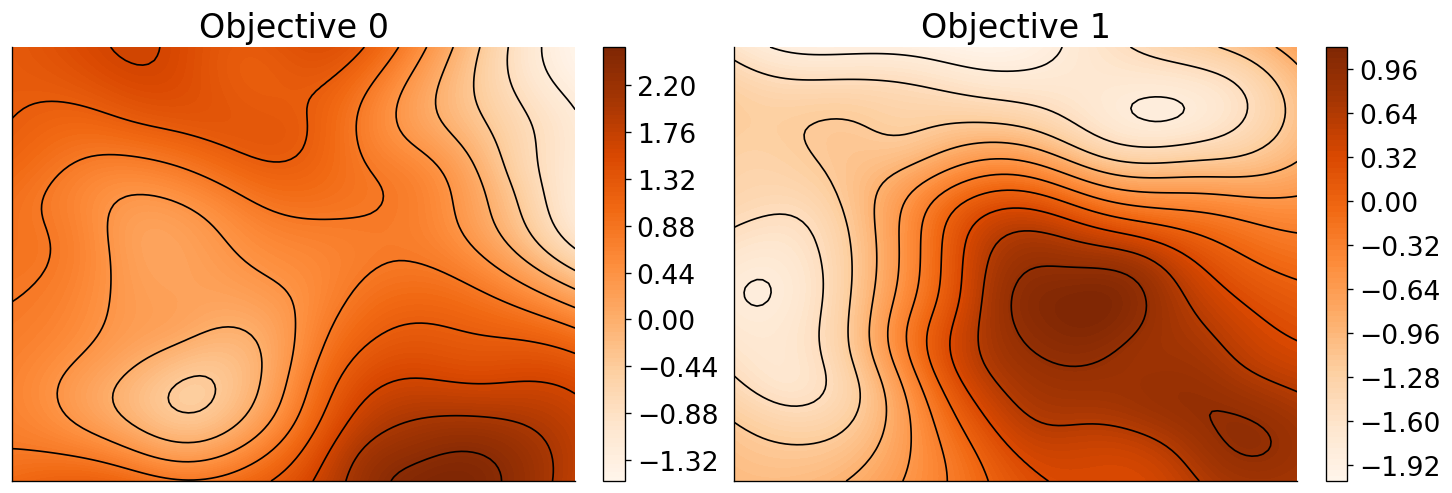

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), dpi=120, constrained_layout=True)

for i in range(2):
    ax = axs[i]
    ctr = ax.contourf(x, y, f[..., i], levels=100, cmap="Oranges")
    ax.contour(x, y, f[..., i], levels=10, colors="black", linewidths=1, linestyles="solid")
    fig.colorbar(ctr, ax=ax).ax.tick_params(labelsize=16)

    ax.set_title(f"Objective {i}", fontsize=20)
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

## Computing the Pareto front
We can also use NSGA-II to compute the Pareto front.

In [7]:
%%time
p_set, p_front = sample_points_on_pareto_front(BoTorchProblem(problem), npoints=1000)

CPU times: user 21.6 s, sys: 89 ms, total: 21.7 s
Wall time: 8.83 s


We plot the Pareto front using the helper function `pygmo.plot_non_dominated_fronts()`. We must bare in mind that the steps plotted using this method are inverted though, because the functions is designed to be used to plot the Pareto front of a minimisation problem.

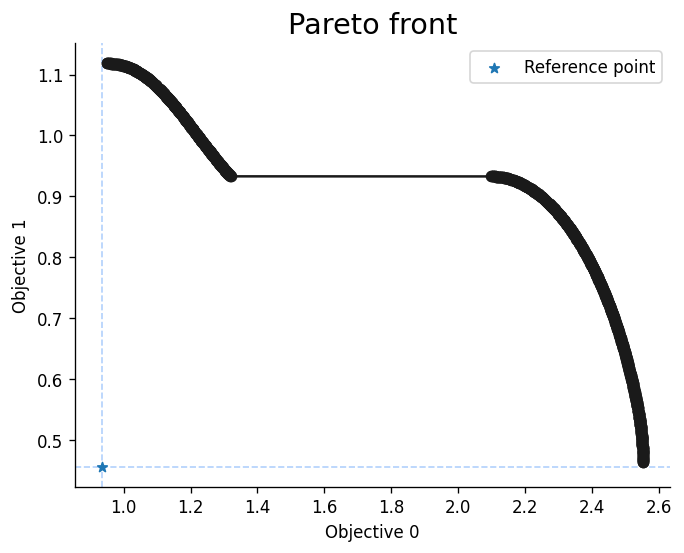

In [8]:
plt.figure(dpi=120)
plt.axvline(problem.ref_point[0], color="xkcd:powder blue", linestyle="--", linewidth=1, zorder=1)
plt.axhline(problem.ref_point[1], color="xkcd:powder blue", linestyle="--", linewidth=1, zorder=1)
plt.scatter([problem.ref_point[0]], [problem.ref_point[1]], marker="*", color="tab:blue", label="Reference point")
pygmo.plot_non_dominated_fronts(p_front, axes=plt.gca())
plt.title("Pareto front", fontsize="xx-large")
plt.xlabel("Objective 0")
plt.ylabel("Objective 1")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.legend()
None